In [17]:
"""
These codes serve for Hgb evaluation with LSTM and procedure-based GNN
** Ground truth (whether to draw Hgb): abs(next_value - current_value) / current_value <= 0.03 -> not draw **
"""

'\nThese codes serve for Hgb evaluation with LSTM and procedure-based GNN\n** Ground truth (whether to draw Hgb): abs(next_value - current_value) / current_value <= 0.03 -> not draw **\n'

time: 2.17 ms


In [2]:
%load_ext autotime

time: 205 µs


In [3]:
index_run = 1

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
# The PyG built-in GCNConv
import networkx as nx
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
import gym

from sklearn.metrics import roc_curve, auc, roc_auc_score, \
precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"]="10,11,12"
os.environ['CUDA_LAUNCH_BLOCKING'] = '11'

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


time: 4.55 s


In [6]:
main_device_id = 12
torch.cuda.set_device(main_device_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

print(device)

cuda
time: 366 ms


# Load Data and Preprocessing

In [18]:
# KKK = 1
train_dir = 'data/comb/train/'
output_dir = 'data/comb/output/'

lab_test_data = pd.read_csv(train_dir + 'lab_test_data.csv')
vital_data = pd.read_csv(train_dir + 'vital_data.csv')
normal_range = pd.read_csv(train_dir + 'normal_range.csv')
not_nan_mask = pd.read_csv(train_dir + 'not_nan_mask.csv')
abnormal_mask = pd.read_csv(train_dir + 'abnormal_mask.csv')
visit_mask = pd.read_csv(train_dir + 'visit_mask.csv')
visit_times_list = pd.read_csv(train_dir + 'visit_times_list.csv')
radiology_scores = pd.read_csv(train_dir + 'radiology_scores.csv')
# patient_map = pd.read_csv(train_dir + 'patient_map.csv')
patient_graph = nx.read_edgelist(train_dir + 'gcs_edgelist.txt')

time: 3.64 s


In [19]:
lab_test_data.shape, vital_data.shape, visit_times_list.shape, visit_mask.shape, radiology_scores.shape

((26700, 20), (178000, 14), (890, 2), (26700, 3), (890, 5))

time: 2.67 ms


In [20]:
lab_test_data['Sex_code'].unique(), lab_test_data['Race_code'].unique()

(array([1, 0]), array([0, 3, 5, 1, 4, 2]))

time: 3.57 ms


In [21]:
lab_test_data['time_offset'].fillna(0, inplace=True)
delta_time_all = lab_test_data['time_offset'][1:].values - lab_test_data['time_offset'][:-1].values
delta_time_all[delta_time_all<0] = 0
delta_time_all = np.concatenate([np.zeros([1]), delta_time_all],0)
lab_test_data['delta_time'] = delta_time_all
display(lab_test_data.head())

vital_delta_time_all = vital_data['time_offset_int'][1:].values - vital_data['time_offset_int'][:-1].values
vital_delta_time_all[vital_delta_time_all<0] = 0
vital_delta_time_all = np.concatenate([np.zeros([1]),vital_delta_time_all],0)
vital_data['delta_time'] = vital_delta_time_all
display(vital_data.head())

display(normal_range)

person_f_list = lab_test_data[['Financial Number','Sex_code','Race_code']].groupby('Financial Number').first()
display(person_f_list)


# Set 'Financial Number' as main index
lab_test_data.set_index('Financial Number', inplace=True)
vital_data.set_index('Financial Number', inplace=True)
normal_range.set_index('Financial Number', inplace=True)
not_nan_mask.set_index('Financial Number', inplace=True)
abnormal_mask.set_index('Financial Number', inplace=True)
visit_mask.set_index('Financial Number', inplace=True)
visit_times_list.set_index('Financial Number', inplace=True)
radiology_scores.set_index('Financial Number', inplace=True)

clinical_list = (radiology_scores - radiology_scores.min()) / (radiology_scores.max() - radiology_scores.min())
display(clinical_list)

# Calculate transition rate
hgb_forward_pad = lab_test_data['Hgb'].replace(0, method='ffill')
hgb_transitions = hgb_forward_pad.groupby('Financial Number').apply(lambda x: x.pct_change().abs())
display(hgb_transitions.head())

# Randomly split dataset: 80/20
correspond_id_all = list(lab_test_data.index.unique())
patient_map_fn2id = dict(zip(sorted(correspond_id_all), range(len(correspond_id_all))))

np.random.seed(753)
np.random.shuffle(correspond_id_all)
train_length = int(0.8*len(correspond_id_all))
display((train_length, len(correspond_id_all)-train_length))
train_patient_list = correspond_id_all[:train_length]
test_patient_list = correspond_id_all[train_length:]

train_lab_test = lab_test_data[lab_test_data.index.isin(train_patient_list)]
train_vital = vital_data[vital_data.index.isin(train_patient_list)]
train_normal_range = normal_range[normal_range.index.isin(train_patient_list)]
train_not_nan_mask = not_nan_mask[not_nan_mask.index.isin(train_patient_list)]
train_abnormal_mask = abnormal_mask[abnormal_mask.index.isin(train_patient_list)]
train_visit_mask = visit_mask[visit_mask.index.isin(train_patient_list)]
train_visit_times_list = visit_times_list[visit_times_list.index.isin(train_patient_list)]
train_person_f_list = person_f_list[person_f_list.index.isin(train_patient_list)]
train_clinical_list = clinical_list[clinical_list.index.isin(train_patient_list)]
train_hgb_trainsitions = hgb_transitions[hgb_transitions.index.isin(train_patient_list)]

test_lab_test = lab_test_data[lab_test_data.index.isin(test_patient_list)]
test_vital = vital_data[vital_data.index.isin(test_patient_list)]
test_normal_range = normal_range[normal_range.index.isin(test_patient_list)]
test_not_nan_mask = not_nan_mask[not_nan_mask.index.isin(test_patient_list)]
test_abnormal_mask = abnormal_mask[abnormal_mask.index.isin(test_patient_list)]
test_visit_mask = visit_mask[visit_mask.index.isin(test_patient_list)]
test_visit_times_list = visit_times_list[visit_times_list.index.isin(test_patient_list)]
test_person_f_list = person_f_list[person_f_list.index.isin(test_patient_list)]
test_clinical_list = clinical_list[clinical_list.index.isin(test_patient_list)]
test_hgb_trainsitions = hgb_transitions[hgb_transitions.index.isin(train_patient_list)]

Financial Number  time_offset   BUN   Ca     Cl   Cr  Fibrinogen  HCO3  \
0      330067549367     0.001944   0.0  0.0    0.0  0.0         0.0   0.0   
1      330067549367     0.003333  10.0  8.5  114.0  1.2         0.0   0.0   
2      330067549367     0.661389   0.0  0.0    0.0  0.0         0.0  28.0   
3      330067549367     0.911389   0.0  0.0    0.0  0.0         0.0  15.0   
4      330067549367     1.128056   0.0  0.0    0.0  0.0         0.0  25.0   

    Hct   Hgb  ...   Mg     Na   PT  PTT    Plt   WBC  Sex_code  Race_code  \
0  36.2  11.3  ...  0.0    0.0  0.0  0.0  169.0  21.6         1          0   
1   0.0   0.0  ...  5.7  148.0  0.0  0.0    0.0   0.0         1          0   
2   0.0   0.0  ...  0.0    0.0  0.0  0.0    0.0   0.0         1          0   
3   0.0   0.0  ...  0.0    0.0  0.0  0.0    0.0   0.0         1          0   
4   0.0   0.0  ...  0.0    0.0  0.0  0.0    0.0   0.0         1          0   

   Age- Years (Visit)  delta_time  
0                16.0    0.000000  
1                16.0    0.001389  
2                16.0    0.658056  
3                16.0    0.250000  
4                16.0    0.216667  

[5 rows x 21 columns]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


Financial Number  time_offset_int  Heart Rate_mean  \
0      3.300675e+11              0.0              0.0   
1      3.300675e+11              1.0              0.0   
2      3.300675e+11              3.0              0.0   
3      3.300675e+11              4.0              0.0   
4      3.300675e+11              5.0              0.0   

   Mean Arterial Pressure_mean  Respiratory Rate_mean  SpO2 percent_mean  \
0                          0.0                   15.6               89.8   
1                          0.0                   18.0              100.0   
2                          0.0                   18.0              100.0   
3                          0.0                   13.0              100.0   
4                          0.0                    0.0              100.0   

   Diastolic Blood Pressure_mean  Systolic Blood Pressure_mean  \
0                           34.6                          97.4   
1                           31.0                         108.0   
2                           31.5                          78.5   
3                           49.0                          91.5   
4                            0.0                           0.0   

   Heart Rate_var  Mean Arterial Pressure_var  Respiratory Rate_var  \
0             0.0                         0.0                   3.3   
1             0.0                         0.0                   0.0   
2             0.0                         0.0                   2.0   
3             0.0                         0.0                   2.0   
4             0.0                         0.0                   0.0   

   SpO2 percent_var  Diastolic Blood Pressure_var  \
0              21.2                         140.8   
1               0.0                           0.0   
2               0.0                          40.5   
3               0.0                           0.0   
4               0.0                           0.0   

   Systolic Blood Pressure_var  delta_time  
0                        132.8         0.0  
1                          0.0         1.0  
2                         60.5         2.0  
3                          0.5         1.0  
4                          0.0         1.0

Financial Number  Normal High_BUN  Normal High_Ca  Normal High_Cl  \
0        330067549367             22.0            10.5           109.0   
1        330726420205             22.0            10.5           109.0   
2        330941951295             22.0            10.5           109.0   
3        333537343304             22.0            10.5           109.0   
4        335442834288             22.0            10.5           109.0   
..                ...              ...             ...             ...   
885      473230049367             22.0            10.5           109.0   
886      550865400062             22.0            10.5           109.0   
887      551953787501             22.0            10.5           109.0   
888      851562193314             22.0            10.5           109.0   
889      854609247500             22.0            10.5           109.0   

     Normal High_Cr  Normal High_Fibrinogen  Normal High_HCO3  \
0               1.4                   510.0              26.0   
1               1.4                   400.0              26.0   
2               1.4                   400.0              26.0   
3               1.4                   400.0              26.0   
4               1.4                   400.0              26.0   
..              ...                     ...               ...   
885             1.4                   510.0              26.0   
886             1.4                   400.0              26.0   
887             1.4                   400.0              26.0   
888             1.4                   400.0              26.0   
889             1.4                   510.0              26.0   

     Normal High_Hct  Normal High_Hgb  Normal High_K  ...  Normal Low_HCO3  \
0               54.0             18.0            5.1  ...             22.0   
1               54.0             18.0            5.1  ...             22.0   
2               54.0             18.0            5.1  ...             22.0   
3               48.0             16.0            5.1  ...             22.0   
4               48.0             16.0            5.1  ...             22.0   
..               ...              ...            ...  ...              ...   
885             40.5             13.5            5.1  ...             22.0   
886             54.0             18.0            5.1  ...             22.0   
887             46.5             15.5            5.1  ...             22.0   
888             54.0             18.0            5.1  ...             22.0   
889             54.0             18.0            5.1  ...             22.0   

     Normal Low_Hct  Normal Low_Hgb  Normal Low_K  Normal Low_Mg  \
0              42.0            14.0           3.5            1.8   
1              42.0            14.0           3.5            1.8   
2              42.0            14.0           3.5            1.8   
3              36.0            12.0           3.5            1.8   
4              36.0            12.0           3.5            1.8   
..              ...             ...           ...            ...   
885            31.5            10.5           3.5            1.8   
886            42.0            14.0           3.5            1.8   
887            34.5            11.5           3.5            1.8   
888            42.0            14.0           3.5            1.8   
889            42.0            14.0           3.5            1.8   

     Normal Low_Na  Normal Low_PT  Normal Low_PTT  Normal Low_Plt  \
0            135.0           12.0            22.9           133.0   
1            135.0           12.1            23.8           133.0   
2            135.0           10.0            30.0           133.0   
3            135.0           10.0            30.0           133.0   
4            135.0           12.0            22.9           133.0   
..             ...            ...             ...             ...   
885          135.0           12.0            22.9           133.0   
886          135.0           

Sex_code  Race_code
Financial Number                     
330067549367             1          0
330726420205             1          0
330941951295             1          0
333537343304             0          3
335442834288             0          5
...                    ...        ...
473230049367             1          1
550865400062             1          3
551953787501             1          3
851562193314             1          5
854609247500             1          5

[890 rows x 2 columns]

GCS  FAST Result_code  Liver AIS(Grade)  Spleen AIS(Grade)
Financial Number                                                            
330067549367      0.0              0.85               0.0                0.0
330726420205      1.0              0.40               0.6                0.0
330941951295      1.0              0.85               0.4                0.0
333537343304      1.0              0.85               0.6                0.0
335442834288      1.0              0.85               0.0                0.4
...               ...               ...               ...                ...
473230049367      0.0              0.85               0.0                0.0
550865400062      0.0              0.85               0.0                0.0
551953787501      0.0              0.85               0.0                0.0
851562193314      0.0              0.85               0.0                0.0
854609247500      0.0              0.85               0.0                0.0

[890 rows x 4 columns]

Financial Number
330067549367    NaN
330067549367    0.0
330067549367    0.0
330067549367    0.0
330067549367    0.0
Name: Hgb, dtype: float64

(712, 178)

time: 1.05 s


In [22]:
patient_graph = nx.convert_node_labels_to_integers(patient_graph)
# add Financial Number to node list
nx.set_node_attributes(patient_graph, dict(zip(range(len(correspond_id_all)),sorted(correspond_id_all))), 'fn')
nx.set_node_attributes(patient_graph, dict(zip(range(len(correspond_id_all)),clinical_list['GCS'])), 'gcs')

time: 525 ms


In [23]:
train_lab_test.shape, test_lab_test.shape,test_lab_test.index.nunique()

((21360, 20), (5340, 20), 178)

time: 2.89 ms


In [24]:
train_not_nan_mask[train_not_nan_mask.columns[1:]].values.sum(), train_not_nan_mask[train_not_nan_mask.columns[1:]].shape[0]*train_not_nan_mask[train_not_nan_mask.columns[1:]].shape[1]

(43729.0, 320400)

time: 7.89 ms


In [25]:
len(lab_test_data['Hgb'][lab_test_data['Hgb']>0]),(test_lab_test['Hgb']!=0).sum()

(6654, 1428)

time: 4.05 ms


In [26]:
lab_test_data.columns

Index(['time_offset', 'BUN', 'Ca', 'Cl', 'Cr', 'Fibrinogen', 'HCO3', 'Hct',
       'Hgb', 'K', 'Mg', 'Na', 'PT', 'PTT', 'Plt', 'WBC', 'Sex_code',
       'Race_code', 'Age- Years (Visit)', 'delta_time'],
      dtype='object')

time: 2.61 ms


# Hyper-parameter Definition

In [39]:
param_args = {
    # model params
    'len_time': 30,
    'cut_len': 20,
    'test_num': 15,
    'corrupt_coef': 0.9,
    'hgb_output_panel_indexset': [7,13,14],
    'hgb_index': 7,
    'reduced_num': 3,
    'bias_cut_tau': [0.03,0.06,0.1,0.15,0.2],
    
    # hyper-params
    'batch_size': 32,
    'num_workers': 1,
    'dropout_prob': 0.0,
    'learning_rate': 0.005,
    'lambda_weight_decay': 0.000001,
    'weight_hgb': torch.Tensor([3,1,1]).to(device),
    'transition_rate': 0.06,
    'thresholds': np.arange(0,1,0.05)+0.05
}

# relative index
param_args['hgb_index'] = param_args['hgb_output_panel_indexset'].index(param_args['hgb_index'])

time: 2.53 ms


# Build Dataset

In [40]:
from torch_geometric.data import Data, Dataset, DataLoader

class GraphDataset(Dataset):    
    def __init__(self, 
                 lab_test_data, visit_mask, visit_times_list, not_nan_mask, hgb_transitions,
                 abnormal_mask, vital_data, correspond_id_all, person_f_list, normal_range,  
                 clinical_list_df, patient_list, patient_map_fn2id):
        
        self.test_data_all = torch.FloatTensor(lab_test_data[lab_test_data.columns[1:1+param_args['test_num']]].values.reshape(-1,param_args['len_time'],param_args['test_num']))
        self.visit_mask_all = torch.FloatTensor(visit_mask['Mask'].values.reshape(-1,param_args['len_time']))
        self.visit_times_all = torch.FloatTensor(visit_times_list['Order Drawn Date & Time'].values)
        self.not_nan_mask = torch.FloatTensor(not_nan_mask[not_nan_mask.columns[1:1+param_args['test_num']]].values.reshape(-1,param_args['len_time'],param_args['test_num']))
        self.hgb_transition = torch.FloatTensor(hgb_transitions.values.reshape(-1,param_args['len_time'])[:,1:])
        self.abnormal_mask = torch.FloatTensor(abnormal_mask[abnormal_mask.columns[1:1+param_args['test_num']]].values.reshape(-1,param_args['len_time'],param_args['test_num']))
        self.delta_time_all = torch.FloatTensor(lab_test_data['delta_time'].values.reshape(-1,param_args['len_time'],1))
#         self.person_f_list = torch.LongTensor(person_f_list.values.reshape(-1,2))
        self.person_f_list = torch.FloatTensor(person_f_list.values.reshape(-1,2)) 
        self.vital_data_all = torch.FloatTensor(vital_data[vital_data.columns[1:13]].values.reshape(-1,200,12))
        self.vital_delta_time_all = torch.FloatTensor(vital_data['delta_time'].values.reshape(-1,200,1))
        self.patient_fn_all = patient_list
        self.patient_map_fn2id = patient_map_fn2id
        self.patient_id_all = torch.LongTensor([self.patient_map_fn2id[fn] for fn in patient_list])
        self.normal_range_all = torch.FloatTensor(normal_range.values.reshape(-1,2,param_args['test_num']))
        self.clinical_list = torch.FloatTensor(clinical_list.values.reshape(-1,4))
        
        self.y = torch.LongTensor(self.patient_id_all) # patient ID list
        self.ALLCOUNT = len(self.test_data_all)
        

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)                         
    
    def __len__(self):
        return self.ALLCOUNT

    def __getitem__(self, idx):
        input_data = self.test_data_all[idx]
        visit_mask = self.visit_mask_all[idx]
        visit_times = self.visit_times_all[idx]
        not_nan_mask = self.not_nan_mask[idx]
        hgb_transitions = self.hgb_transitions[idx]
        abnormal_mask = self.abnormal_mask[idx]
        delta_time_all = self.delta_time_all[idx]
        person_f_list = self.person_f_list[idx]
        vital_data_all = self.vital_data_all[idx]
        vital_delta_time_all = self.vital_delta_time_all[idx]
        patient_fn_all = self.patient_fn_all[idx]
        patient_id_all = self.patient_id_all[idx]
        normal_range_all = self.normal_range_all[idx]
        clinical_list = self.clinical_list[idx]
        
        sample = {'patient_id_all': patient_id_all, 'patient_fn_all': patient_fn_all,
                  'delta_time_all': delta_time_all,
                  'vital_data_all': vital_data_all,'input_data': input_data,
                  'visit_mask': visit_mask, 'visit_times': visit_times,
                  'abnormal_mask': abnormal_mask, 'not_nan_mask': not_nan_mask,
                  'hgb_transitions': hgb_transitions,
                  'person_f_list': person_f_list,'vital_delta_time_all':vital_delta_time_all,
                  'normal_range_all': normal_range_all,'clinical_list': clinical_list}
        
        return sample

time: 7.64 ms


# Construct Combination Model

In [41]:
class LSTM_model(nn.Module):
    def __init__(self, 
                 lstm_test_dim=60,
                 is_bidirectional=False,
                 pooling='last'):
        super(LSTM_model, self).__init__()
        self.num_panel = param_args['test_num'] # 15
        self.len_time = param_args['len_time'] # 30
        self.lstm_test_dim = lstm_test_dim
        self.pooling = pooling
        self.is_bidirectional = is_bidirectional
        
        self.layers = nn.LSTM(self.num_panel+1,self.lstm_test_dim,num_layers=1, 
                              batch_first=True,bidirectional=self.is_bidirectional)
        self.time_aware_layers = nn.LSTM(self.num_panel+self.lstm_test_dim+1,self.lstm_test_dim,
                                         num_layers=1, batch_first=True,bidirectional=self.is_bidirectional)        
    
    def forward(self,input_batch,test_time): #B L 15       
        # get outputs from the returning tuple
        lstm_out = self.layers(torch.cat([input_batch,test_time],2))[0] #self.layers(input_batch)[0] 
        lstm_out = self.time_aware_layers(torch.cat([lstm_out,input_batch,test_time],2))[0] # B L 60
        
        if self.pooling == 'mean':
            pool_out = torch.mean(lstm_out, 1).squeeze()
        elif self.pooling == 'max':
            pool_out = torch.max(lstm_out, 1)[0].squeeze()
        elif self.pooling == 'last':
            if self.is_bidirectional:
                # only to be used when bidirectional.
                # concat last step of forward dir + first step of backward dir.
                pool_out = torch.cat((lstm_out[:, -1, :self.lstm_test_dim], lstm_out[:, 0, self.lstm_test_dim:]), 1)
            else:
                pool_out = lstm_out[:, -1, :]
        else:
            raise NotImplementedError('only pooling mean / all for now.')
        

        return lstm_out, pool_out

time: 3.81 ms


In [42]:
class GCN_model(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim=64,
                 dropout_prob=0.3):
        super(GCN_model, self).__init__()
        self.output_dim = output_dim
        self.conv1 = GCNConv(input_dim, 256)
        self.conv2 = GCNConv(256, 128)
        self.conv3 = GCNConv(128, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

#             self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index): # B 60
        h = self.conv1(x, edge_index)
        h = self.dropout(h)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = self.dropout(h)
        h = h.relu()
        h = self.conv3(h, edge_index)
        h = h.relu()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
#             out = self.classifier(h)

        return h

time: 2.5 ms


In [43]:
class Comb_model(nn.Module):
    def __init__(self,
                 edge_feature_dim=1, # [GSC]
                 static_input_dim=6,
                 lstm_test_dim=60,
                 gcn_output_dim=64,
                 static_output_dim=30,
                 linear_hidden_dim=128):
        super(Comb_model, self).__init__()
        torch.manual_seed(12345)
        self.lstm_model = LSTM_model(lstm_test_dim=lstm_test_dim)
        self.gcn_model = GCN_model(input_dim=lstm_test_dim+edge_feature_dim, output_dim=gcn_output_dim) # out:64
        self.static_linear = nn.Linear(static_input_dim, static_output_dim)
        # only check Hgb
        self.linear_predict_next_check0 = nn.Linear(lstm_test_dim+gcn_output_dim+static_output_dim,
                                                    linear_hidden_dim)
        self.linear_predict_next_check1 = nn.Linear(linear_hidden_dim, 1)
        # loss function to evaluate Hgb, Plt, WBC
        self.linear_predict_next_value0 = nn.Linear(lstm_test_dim+gcn_output_dim+static_output_dim,
                                                    linear_hidden_dim)
        self.linear_predict_next_value1 = nn.Linear(linear_hidden_dim,3)
        

    def forward(self, 
                lab_values,test_time,person_info,clinical_list,
                batch_node_attr, edge_index,
                return_gcn_embedding=True): # B L 15
        
        size_o = lab_values.size()
        corrupt = torch.rand(size_o) + param_args['corrupt_coef']
        corrupt = corrupt - 0.3
#         corrupt[:,:,param_args['hgb_output_panel_indexset']] = corrupt[:,:,param_args['hgb_output_panel_indexset']]-0.3
        corrupt = corrupt.to(device)
        corrupt[corrupt>1] = 1
        corrupt[corrupt<1] = 0
        lab_values = lab_values*corrupt   
        
#         batch_node_attr = batch_node_attr.repeat((param_args['len_time'],1)).T.unsqueeze(2) # B 30 1
        batch_node_attr = batch_node_attr.unsqueeze(1)
        time_len = lab_values.shape[1]
        lstm_out, pool_out = self.lstm_model(lab_values,test_time) # last pooling -> B L 60, B 60
        
        """
        TO-DO: solve GNN input dimension problem
        """
        gcn_out = self.gcn_model(torch.cat([batch_node_attr, pool_out], dim=1), edge_index) # B 64
        gcn_out = gcn_out.repeat(time_len,1,1).transpose(0,1) # B 30 64
        
        static_out = self.static_linear(torch.cat([person_info,clinical_list], dim=1)) # B 6 -> B 30
        static_out = static_out.repeat(time_len,1,1).transpose(0,1) # B L 30
        
        comb_out = torch.cat([lstm_out, gcn_out, static_out], dim=2) # B 30 60+64+30 
        
        next_check = self.linear_predict_next_check0(comb_out)
        next_check = torch.relu(next_check)
        next_check = self.linear_predict_next_check1(next_check)
        next_check = torch.sigmoid(next_check)
        
        next_value = self.linear_predict_next_value0(comb_out)
        next_value = torch.relu(next_value)
        next_value = self.linear_predict_next_value1(next_value)
        next_value = torch.relu(next_value)
        
        if return_gcn_embedding:
            return (next_check, next_value, gcn_out)
        else:
            return (next_check, next_value)
    

time: 5.88 ms


# Train and Evaluate Model

In [44]:
dataset = GraphDataset(lab_test_data, visit_mask, visit_times_list,
                       not_nan_mask, hgb_transitions, abnormal_mask,
                       vital_data, train_patient_list, person_f_list, normal_range,
                       clinical_list, correspond_id_all, patient_map_fn2id)

comb_model = Comb_model().to(device)
optimizer = torch.optim.Adam(comb_model.parameters(), lr=param_args['learning_rate'], 
                             weight_decay=param_args['lambda_weight_decay'])
comb_model.train()

loss_bce = nn.BCELoss()
loss_mse = nn.MSELoss()

time: 41.6 ms


In [45]:
def get_ground_truth(hgb_transition, nnan_mask, transition_rate=0.03): #0.06
    hgb_transition_truth = hgb_transition.clone()
    hgb_transition_truth[nnan_mask[:,1:]==0] = -1 # NAN
    hgb_transition_truth[(hgb_transition<=transition_rate)&(nnan_mask[:,1:]>0)] = 0 # not draw
    hgb_transition_truth[(hgb_transition>transition_rate)&(nnan_mask[:,1:]>0)] = 1 # draw
    
    return hgb_transition_truth
    

def get_loss(next_value,
             input_value,
             next_check,
             nnan_mask,
             hgb_transition,
             visit_mask,
             normalrange_temp,
             threshold_point=0.5,
             value_error=0.03,
             discount_rate=0.05): 
    
    # ground truth for whether to draw a Hgb test
    hgb_input_value = input_value[:,:,param_args['hgb_index']]
    hgb_nnan_mask = nnan_mask[:,:,param_args['hgb_index']]
    input_transition = get_ground_truth(hgb_transition, hgb_nnan_mask)
    loss0 = loss_bce(next_check[:,:-1].squeeze(2)[input_transition>=0], input_transition[input_transition>=0])
    
#     # MSE for lab values
    scale_normal_range = normalrange_temp[:,1]-normalrange_temp[:,0] # B 1 12
    scale_temp = scale_normal_range.unsqueeze(1)
    
    diff_1 = ((next_value[:,:-1] - input_value[:,1:]) / scale_temp)**2
    diff_2 = next_value[:,:-1] / (input_value[:,1:] + 10e-3)**2
    diff_ = diff_1 + diff_2
        
    # reinforcement learning
    hgb_pre_check_prob = next_check[:,:-1] # B 29 1
    hgb_pre_check = hgb_pre_check_prob.clone()
    hgb_pre_check[hgb_pre_check<threshold_point] = 0
    hgb_pre_check[hgb_pre_check>=threshold_point] = 1
    hgb_pre_check = hgb_pre_check.repeat((1,1,3))
    
    input_value_pad0 = input_value[:,1:].clone()
    input_value_pad0[input_value_pad0==0] = 1
    value_bias = torch.abs(next_value[:,:-1] - input_value[:,1:])/input_value_pad0
    reward_weight = value_bias.clone()
    
    # transition:0(not draw), 1(draw)
    input_transition_dup = input_transition.unsqueeze(2).repeat((1,1,3))
    reward_weight[(hgb_pre_check==0)&(value_bias<=value_error)] = 1 + discount_rate
    reward_weight[(hgb_pre_check==0)&(value_bias>value_error)] = 1 - discount_rate
    reward_weight[(hgb_pre_check==1)&(value_bias<=value_error)] = 1 - discount_rate
    reward_weight[(hgb_pre_check==1)&(value_bias>value_error)] = 1 + discount_rate
    loss1 = - diff_[:,:,0] * nnan_mask[:,1:,0] * torch.log(next_check[:,:-1].squeeze(2)) # hgb MSE
    
    if len(loss1) > 0:
#         nnan_count = torch.sum(nnan_mask[:,1:]).item()
        nnan_count = torch.sum(nnan_mask[:,1:,0]).item()
        loss1 = torch.sum(loss1)/nnan_count
    else:
        loss1 = torch.tensor(0.0)
    
        
    total_loss = (loss0 + loss1)
    
    return total_loss, loss0, loss1


def get_subgraph_edge_data(graph):
    row = torch.LongTensor([e for e in graph.edges])[:,0]
    col = torch.LongTensor([e for e in graph.edges])[:,1]
    edge_index = torch.stack([row, col], dim=0) # 2 Edge_Num
    
    return edge_index


def train(train_mask,
          test_mask,
          save_dir=None,
          model=comb_model,
          data=dataset,
          graph=patient_graph,
          threshold_point=0.5,
          num_epoch=500, 
          n_print_eval=50):
    
    for n_epoch in range(num_epoch+1):
        model.train()
        torch.cuda.empty_cache()
        
        batch_patient_id = data.patient_id_all
        batch_patient_fn = data.patient_fn_all
        batch_input_data = data.test_data_all.to(device)
        batch_pfeature = data.person_f_list.to(device) # B 2
        batch_visit_mask = data.visit_mask_all.to(device).to(device)
        batch_nnan_mask = data.not_nan_mask.to(device)
        batch_hgb_transition = data.hgb_transition.to(device)
        batch_delta_time_all = data.delta_time_all.to(device)
        batch_normal_range = data.normal_range_all.to(device)
        batch_clinical_list = data.clinical_list.to(device)
        batch_edge_index = get_subgraph_edge_data(graph).to(device)
        batch_node_attr = torch.Tensor([graph.nodes[int(id)]['gcs'] for id in batch_patient_id]).to(device)
        
        optimizer.zero_grad()

        next_check, next_value, gcn_embedding = model(batch_input_data,
                                                      batch_delta_time_all,
                                                      batch_pfeature,
                                                      batch_clinical_list,
                                                      batch_node_attr,
                                                      batch_edge_index)

        
        # get training data from train_mask
        train_next_value = next_value[train_mask]
        train_input_data = batch_input_data[train_mask][:,:,param_args['hgb_output_panel_indexset']]
        train_next_check = next_check[train_mask]
        train_nnan_mask = batch_nnan_mask[train_mask][:,:,param_args['hgb_output_panel_indexset']]
        train_hgb_transition = batch_hgb_transition[train_mask]
        train_visit_mask = batch_visit_mask[train_mask]
        train_normal_range = batch_normal_range[train_mask][:,:,param_args['hgb_output_panel_indexset']]
        
        train_input_transition = get_ground_truth(train_hgb_transition, train_nnan_mask[:,:,param_args['hgb_index']])
        
        loss, loss0, loss1 = get_loss(train_next_value, 
                                      train_input_data,
                                      train_next_check,
                                      train_nnan_mask,
                                      train_hgb_transition,
                                      train_visit_mask, 
                                      train_normal_range,
                                      threshold_point)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
            
        if n_epoch % n_print_eval == 0:
            print('-'*50)
            # get # of pos and neg in ground truth
            print('# of Neg and Pos:', torch.sum(train_input_transition==1).item(),
                  torch.sum(train_input_transition==0).item(), 
                  torch.sum(train_input_transition>=0))
            print('Epoch:', n_epoch,'train cost: ',loss.data.item(),\
                  'loss 0:', loss0.data.item(), 'loss 1:', loss1.data.item())
            
            logging.info('Epoch:', n_epoch,'train cost: ',loss.data.item(),\
                         'loss 0:', loss0.data.item(), 'loss 1:', loss1.data.item())
            evaluate(model, test_mask, threshold_point=threshold_point, show_details=True)
    
    if save_dir:
        torch.save(model.state_dict(), save_dir)

def evaluate(model,
             test_mask,
             data=dataset,
             graph=patient_graph,
             show_details=False,
             threshold_point=0.5):  
    model.eval()
    torch.cuda.empty_cache()
    
    batch_patient_id = data.patient_id_all
    batch_patient_fn = data.patient_fn_all
    batch_input_data = data.test_data_all.to(device)
    batch_pfeature = data.person_f_list.to(device) # B 2
    batch_visit_mask = data.visit_mask_all.to(device).to(device)
    batch_nnan_mask = data.not_nan_mask.to(device)
    batch_hgb_transition = data.hgb_transition.to(device)
    batch_delta_time_all = data.delta_time_all.to(device)
    batch_normal_range = data.normal_range_all.to(device)
    batch_clinical_list = data.clinical_list.to(device)
    batch_edge_index = get_subgraph_edge_data(graph).to(device)
    batch_node_attr = torch.Tensor([graph.nodes[int(id)]['gcs'] for id in batch_patient_id]).to(device)
    
    next_check = []
    next_value = []
    gcn_embedding = []

    input_temp = batch_input_data[:,:1,:].clone()

    next_check_unit, next_value_unit, gcn_embedding_unit = model(input_temp,
                                                                 batch_delta_time_all[:,:1],
                                                                 batch_pfeature,
                                                                 batch_clinical_list,
                                                                 batch_node_attr,
                                                                 batch_edge_index)
    
    next_check.append(next_check_unit[:,-1])
    next_value.append(next_value_unit[:,-1])
    gcn_embedding.append(gcn_embedding_unit[:,-1])

    # small probability to test
    for j in range(1,param_args['len_time']):
        temp_temp = next_check[-1].clone().to(device)
        temp_temp[temp_temp>=threshold_point] = 1
        temp_temp[temp_temp<threshold_point] = 0

        nnan_mask_ttemp = batch_nnan_mask[:,(j)].clone()

        nnan_mask_ttemp = nnan_mask_ttemp*temp_temp
        input_temp = torch.cat([input_temp,(batch_input_data[:,(j)]*nnan_mask_ttemp).unsqueeze(1)],1)

        next_check_unit, next_value_unit, gcn_embedding_unit = model(input_temp,
                                                                     batch_delta_time_all[:,:(j+1)],
                                                                     batch_pfeature,
                                                                     batch_clinical_list,
                                                                     batch_node_attr,
                                                                     batch_edge_index)
    
        next_check.append(next_check_unit[:,-1])
        next_value.append(next_value_unit[:,-1])
        gcn_embedding.append(gcn_embedding_unit[:,-1])
        

    next_check = torch.stack(next_check, 1)
    next_value = torch.stack(next_value, 1)
    gcn_embedding = torch.stack(gcn_embedding, 1)
    
    # get test data
    test_next_value = next_value[test_mask]
    test_input_data = batch_input_data[test_mask][:,:,param_args['hgb_output_panel_indexset']]
    test_next_check = next_check[test_mask]
    test_nnan_mask = batch_nnan_mask[test_mask][:,:,param_args['hgb_output_panel_indexset']].long()
    test_hgb_transition = batch_hgb_transition[test_mask]
    test_visit_mask = batch_visit_mask[test_mask].long()
    test_normal_range = batch_normal_range[test_mask][:,:,param_args['hgb_output_panel_indexset']]

    # get test cost
    loss, loss0, loss1 = get_loss(test_next_value, 
                                  test_input_data,
                                  test_next_check,
                                  test_nnan_mask,
                                  test_hgb_transition,
                                  test_visit_mask, 
                                  test_normal_range)
    print('test cost: ',loss.data.item(),\
          'loss 0:', loss0.data.item(), 'loss 1:', loss1.data.item())
    logging.info('test cost: ',loss.data.item(),\
          'loss 0:', loss0.data.item(), 'loss 1:', loss1.data.item())
    
    # neg:1(draw), pos:0(not draw), hgb_index:0
    hgb_input_value = test_input_data[:,:,param_args['hgb_index']]
    hgb_nnan_mask = test_nnan_mask[:,:,param_args['hgb_index']]
    hgb_next_value = test_next_value[:,:,param_args['hgb_index']]
    hgb_input_transition = get_ground_truth(test_hgb_transition, hgb_nnan_mask) # B 29
    hgb_pre_check_prob = test_next_check[:,:-1].squeeze(2) # B 29
    hgb_pre_check = hgb_pre_check_prob.clone()
    hgb_pre_check[hgb_pre_check<threshold_point] = 0
    hgb_pre_check[hgb_pre_check>=threshold_point] = 1
    
    visit_mask_flag = test_visit_mask[:,1:] > 0    
    
    y_true = hgb_input_transition[hgb_input_transition>=0].cpu().data
    y_pred = hgb_pre_check[hgb_input_transition>=0].cpu().data
    y_pred_prob = hgb_pre_check_prob[hgb_input_transition>=0].cpu().data
    
    # Evaluaton 1: whether to draw lab tests
    hgb_check_auc = roc_auc_score(y_true, y_pred_prob)
    print(confusion_matrix(y_true, y_pred))
    tp, fn, fp, tn = confusion_matrix(y_true, y_pred).ravel()
    hgb_check_accuracy = (tn + tp) / (tn + fp + fn + tp)
    hgb_check_precision = tp / (tp + fp) # PPV
    hgb_check_npv = tn / (tn + fn) # NPV
    hgb_check_recall = tp / (tp + fn) # TPR
    hgb_check_specificity = tn / (tn + fp) # 1 - FPR
    hgb_check_f1 = 2 * (hgb_check_precision * hgb_check_recall) / (hgb_check_precision + hgb_check_recall)
    print('Hgb AUC:{}, accuracy:{}, precision:{}, recall:{}, specificity:{}, f1:{}'.format(hgb_check_auc,\
                                                                                           hgb_check_accuracy,
                                                                                           hgb_check_precision,\
                                                                                           hgb_check_recall,\
                                                                                           hgb_check_specificity,\
                                                                                           hgb_check_f1))
    
    # Evaluation 2: value prediction in overall
    # Evaluation 3: value prediction in reduced part
    hgb_nnan_reduce = 1 - y_pred
    reduce_prop = (tp + fp) / (tp + fp + fn + tn)
    print('reduce num:', torch.sum(hgb_nnan_reduce).item())
    print('reduce prop:', reduce_prop)
    
    result_temp = {}
    if reduce_prop > 0:
        hgb_input_value_pad0 = hgb_input_value[:,1:][hgb_nnan_mask[:,1:]>0].clone() # true values
        hgb_input_value_pad0[hgb_input_value_pad0==0] = 1
        hgb_value_bias = torch.abs(hgb_input_value[:,1:][hgb_nnan_mask[:,1:]>0] - hgb_next_value[:,:-1][hgb_nnan_mask[:,1:]>0]) / hgb_input_value_pad0
        hgb_reduced_value_bias = hgb_value_bias[hgb_nnan_reduce>0]

        
        for xx in param_args['bias_cut_tau']:
            # prop of bias within xx range
            if hgb_reduced_value_bias.size()[0] == 0:
                print('reduce: 0')
                continue
            accuracy_unit = torch.sum(hgb_value_bias<xx).item()/hgb_value_bias.size()[0]
            reduced_accuracy_unit = torch.sum(hgb_reduced_value_bias<xx).item()/hgb_reduced_value_bias.size()[0]
            result_temp[xx] = (accuracy_unit, reduced_accuracy_unit)
        print('Value prediction accuracies:', result_temp)

        if show_details:
            plt.hist(hgb_reduced_value_bias.cpu().data.numpy(), 100)
            plt.xlabel('Value Error')
            plt.ylabel('Frequency')
            plt.show()
        
    return reduce_prop, result_temp, hgb_check_accuracy, hgb_check_auc, hgb_check_recall, hgb_check_specificity

time: 24.5 ms


## Train the Model with Threshold=0.5

--------------------------------------------------
# of Neg and Pos: 3049 1469 tensor(4518, device='cuda:12')
Epoch: 0 train cost:  6.571518421173096 loss 0: 0.6839310526847839 loss 1: 5.887587547302246
test cost:  4.022039890289307 loss 0: 0.6333412528038025 loss 1: 3.3886988162994385
[[  0 410]
 [  0 842]]
Hgb AUC:0.5098589305370489, accuracy:0.6725239616613419, precision:nan, recall:0.0, specificity:1.0, f1:nan
reduce num: 0.0
reduce prop: 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in long_scalars


--------------------------------------------------
# of Neg and Pos: 3049 1469 tensor(4518, device='cuda:12')
Epoch: 50 train cost:  0.7587689161300659 loss 0: 0.6478031873703003 loss 1: 0.11096570640802383
test cost:  1.0526201725006104 loss 0: 0.6771833896636963 loss 1: 0.3754367232322693
[[  0 410]
 [  0 842]]
Hgb AUC:0.5410260123978912, accuracy:0.6725239616613419, precision:nan, recall:0.0, specificity:1.0, f1:nan
reduce num: 0.0
reduce prop: 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in long_scalars


--------------------------------------------------
# of Neg and Pos: 3049 1469 tensor(4518, device='cuda:12')
Epoch: 100 train cost:  0.7243878841400146 loss 0: 0.6286643147468567 loss 1: 0.09572354704141617
test cost:  0.9811363220214844 loss 0: 0.6517274379730225 loss 1: 0.3294089138507843
[[  0 410]
 [  0 842]]
Hgb AUC:0.5594229766525693, accuracy:0.6725239616613419, precision:nan, recall:0.0, specificity:1.0, f1:nan
reduce num: 0.0
reduce prop: 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in long_scalars


--------------------------------------------------
# of Neg and Pos: 3049 1469 tensor(4518, device='cuda:12')
Epoch: 150 train cost:  0.7018376588821411 loss 0: 0.6247252225875854 loss 1: 0.07711245119571686
test cost:  1.110598087310791 loss 0: 0.6566435098648071 loss 1: 0.4539546072483063
[[  0 410]
 [  0 842]]
Hgb AUC:0.5701436764961474, accuracy:0.6725239616613419, precision:nan, recall:0.0, specificity:1.0, f1:nan
reduce num: 0.0
reduce prop: 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in long_scalars


--------------------------------------------------
# of Neg and Pos: 3049 1469 tensor(4518, device='cuda:12')
Epoch: 200 train cost:  0.6948755383491516 loss 0: 0.6164319515228271 loss 1: 0.07844358682632446
test cost:  1.0506163835525513 loss 0: 0.6544141173362732 loss 1: 0.39620229601860046
[[  0 410]
 [  0 842]]
Hgb AUC:0.5830253171890388, accuracy:0.6725239616613419, precision:nan, recall:0.0, specificity:1.0, f1:nan
reduce num: 0.0
reduce prop: 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in long_scalars


--------------------------------------------------
# of Neg and Pos: 3049 1469 tensor(4518, device='cuda:12')
Epoch: 250 train cost:  0.6761745810508728 loss 0: 0.6006578207015991 loss 1: 0.07551677525043488
test cost:  1.1689845323562622 loss 0: 0.6629077196121216 loss 1: 0.5060768127441406
[[  0 410]
 [  0 842]]
Hgb AUC:0.570827298534268, accuracy:0.6725239616613419, precision:nan, recall:0.0, specificity:1.0, f1:nan
reduce num: 0.0
reduce prop: 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in long_scalars


--------------------------------------------------
# of Neg and Pos: 3049 1469 tensor(4518, device='cuda:12')
Epoch: 300 train cost:  0.662875771522522 loss 0: 0.5898167490959167 loss 1: 0.07305905222892761
test cost:  0.9990372657775879 loss 0: 0.663474977016449 loss 1: 0.33556225895881653
[[ 23 387]
 [ 21 821]]
Hgb AUC:0.5745524593013152, accuracy:0.6741214057507987, precision:0.5227272727272727, recall:0.05609756097560976, specificity:0.9750593824228029, f1:0.1013215859030837
reduce num: 44.0
reduce prop: 0.03514376996805112
Value prediction accuracies: {0.03: (0.18929712460063897, 0.3409090909090909), 0.06: (0.33386581469648563, 0.5454545454545454), 0.1: (0.5343450479233227, 0.8409090909090909), 0.15: (0.6908945686900958, 0.9545454545454546), 0.2: (0.8099041533546326, 0.9772727272727273)}


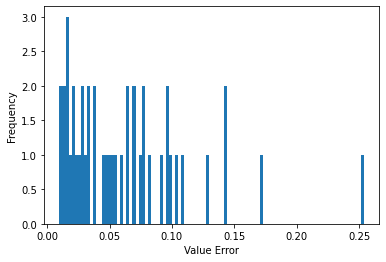

--------------------------------------------------
# of Neg and Pos: 3049 1469 tensor(4518, device='cuda:12')
Epoch: 350 train cost:  0.6473678350448608 loss 0: 0.5829182267189026 loss 1: 0.06444962322711945
test cost:  1.216235637664795 loss 0: 0.6839153170585632 loss 1: 0.5323203206062317
[[ 40 370]
 [ 64 778]]
Hgb AUC:0.5693383929088697, accuracy:0.6533546325878594, precision:0.38461538461538464, recall:0.0975609756097561, specificity:0.9239904988123515, f1:0.1556420233463035
reduce num: 104.0
reduce prop: 0.08306709265175719
Value prediction accuracies: {0.03: (0.16693290734824281, 0.375), 0.06: (0.33226837060702874, 0.5384615384615384), 0.1: (0.5343450479233227, 0.75), 0.15: (0.6956869009584664, 0.8557692307692307), 0.2: (0.8146964856230032, 0.9038461538461539)}


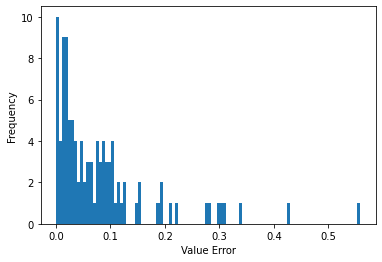

--------------------------------------------------
# of Neg and Pos: 3049 1469 tensor(4518, device='cuda:12')
Epoch: 400 train cost:  0.6253339052200317 loss 0: 0.5542312264442444 loss 1: 0.07110267132520676
test cost:  1.1642541885375977 loss 0: 0.7031289935112 loss 1: 0.46112513542175293
[[ 44 366]
 [ 53 789]]
Hgb AUC:0.5890794276113783, accuracy:0.6653354632587859, precision:0.4536082474226804, recall:0.1073170731707317, specificity:0.9370546318289786, f1:0.17357001972386585
reduce num: 97.0
reduce prop: 0.07747603833865814
Value prediction accuracies: {0.03: (0.1733226837060703, 0.30927835051546393), 0.06: (0.3490415335463259, 0.5051546391752577), 0.1: (0.5359424920127795, 0.7010309278350515), 0.15: (0.7420127795527156, 0.8865979381443299), 0.2: (0.8434504792332268, 0.9381443298969072)}


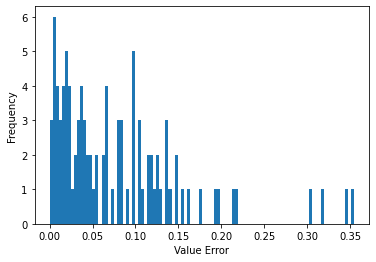

--------------------------------------------------
# of Neg and Pos: 3049 1469 tensor(4518, device='cuda:12')
Epoch: 450 train cost:  0.6080026626586914 loss 0: 0.5337151885032654 loss 1: 0.07428745925426483
test cost:  1.2321449518203735 loss 0: 0.7513840198516846 loss 1: 0.4807609021663666
[[ 48 362]
 [ 62 780]]
Hgb AUC:0.5564886159550432, accuracy:0.6613418530351438, precision:0.43636363636363634, recall:0.11707317073170732, specificity:0.9263657957244655, f1:0.1846153846153846
reduce num: 110.0
reduce prop: 0.0878594249201278
Value prediction accuracies: {0.03: (0.1853035143769968, 0.2545454545454545), 0.06: (0.34185303514376997, 0.4909090909090909), 0.1: (0.5279552715654952, 0.6727272727272727), 0.15: (0.6964856230031949, 0.8545454545454545), 0.2: (0.8035143769968051, 0.9181818181818182)}


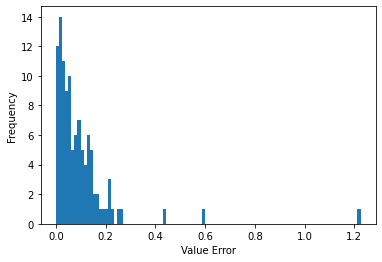

--------------------------------------------------
# of Neg and Pos: 3049 1469 tensor(4518, device='cuda:12')
Epoch: 500 train cost:  0.5834535360336304 loss 0: 0.517515242099762 loss 1: 0.06593827903270721
test cost:  1.2133698463439941 loss 0: 0.7621251940727234 loss 1: 0.451244592666626
[[ 91 319]
 [139 703]]
Hgb AUC:0.5584525809628642, accuracy:0.634185303514377, precision:0.39565217391304347, recall:0.22195121951219512, specificity:0.834916864608076, f1:0.284375
reduce num: 230.0
reduce prop: 0.18370607028753994
Value prediction accuracies: {0.03: (0.1781150159744409, 0.2), 0.06: (0.3426517571884984, 0.4260869565217391), 0.1: (0.5343450479233227, 0.6304347826086957), 0.15: (0.7044728434504792, 0.7913043478260869), 0.2: (0.8123003194888179, 0.8521739130434782)}


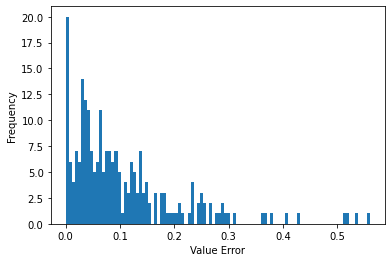

--END--
time: 2min 3s


In [46]:
train_mask = [patient_map_fn2id[fn] for fn in train_patient_list]
test_mask = [patient_map_fn2id[fn] for fn in test_patient_list]

train(train_mask=train_mask, 
      test_mask=test_mask,
      save_dir=output_dir+'exp3')

print('--END--')

## Evaluate Model with A Series of Checking Proportions

test cost:  1.0056636333465576 loss 0: 0.7645028829574585 loss 1: 0.24116076529026031
[[  0 410]
 [  0 842]]
Hgb AUC:0.5513180001158682, accuracy:0.6725239616613419, precision:nan, recall:0.0, specificity:1.0, f1:nan
reduce num: 0.0
reduce prop: 0.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in long_scalars


test cost:  1.3361408710479736 loss 0: 0.7568060755729675 loss 1: 0.5793347954750061
[[  0 410]
 [  1 841]]
Hgb AUC:0.5580325589479173, accuracy:0.6717252396166135, precision:0.0, recall:0.0, specificity:0.998812351543943, f1:nan
reduce num: 1.0
reduce prop: 0.0007987220447284345
Value prediction accuracies: {0.03: (0.1829073482428115, 0.0), 0.06: (0.3466453674121406, 0.0), 0.1: (0.5311501597444089, 1.0), 0.15: (0.6988817891373802, 1.0), 0.2: (0.8186900958466453, 1.0)}


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:265: RuntimeWarning: invalid value encountered in double_scalars


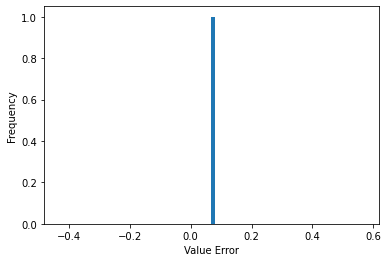

test cost:  1.2419813871383667 loss 0: 0.7599538564682007 loss 1: 0.482027530670166
[[  0 410]
 [  1 841]]
Hgb AUC:0.549345344997393, accuracy:0.6717252396166135, precision:0.0, recall:0.0, specificity:0.998812351543943, f1:nan
reduce num: 1.0
reduce prop: 0.0007987220447284345
Value prediction accuracies: {0.03: (0.19329073482428116, 0.0), 0.06: (0.3402555910543131, 1.0), 0.1: (0.5239616613418531, 1.0), 0.15: (0.7092651757188498, 1.0), 0.2: (0.8170926517571885, 1.0)}


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:265: RuntimeWarning: invalid value encountered in double_scalars


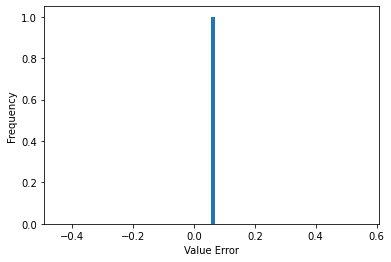

test cost:  1.6588077545166016 loss 0: 0.7828784584999084 loss 1: 0.8759293556213379
[[  1 409]
 [  3 839]]
Hgb AUC:0.5352355019987254, accuracy:0.670926517571885, precision:0.25, recall:0.0024390243902439024, specificity:0.996437054631829, f1:0.004830917874396135
reduce num: 4.0
reduce prop: 0.003194888178913738
Value prediction accuracies: {0.03: (0.17731629392971246, 0.0), 0.06: (0.34345047923322686, 0.75), 0.1: (0.5199680511182109, 0.75), 0.15: (0.6996805111821086, 0.75), 0.2: (0.8043130990415336, 0.75)}


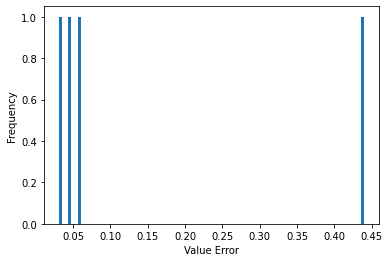

test cost:  1.4194929599761963 loss 0: 0.7528285980224609 loss 1: 0.6666644215583801
[[  4 406]
 [  8 834]]
Hgb AUC:0.5490093273854353, accuracy:0.6693290734824281, precision:0.3333333333333333, recall:0.00975609756097561, specificity:0.9904988123515439, f1:0.018957345971563982
reduce num: 12.0
reduce prop: 0.009584664536741214
Value prediction accuracies: {0.03: (0.19329073482428116, 0.3333333333333333), 0.06: (0.36900958466453676, 0.5833333333333334), 0.1: (0.5455271565495208, 1.0), 0.15: (0.713258785942492, 1.0), 0.2: (0.8218849840255591, 1.0)}


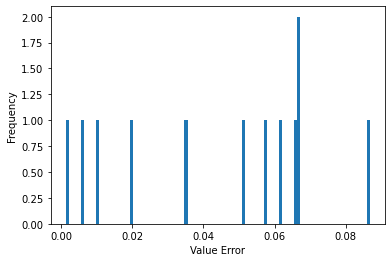

test cost:  2.081324577331543 loss 0: 0.7760176062583923 loss 1: 1.3053069114685059
[[  7 403]
 [ 15 827]]
Hgb AUC:0.5491483691559006, accuracy:0.6661341853035144, precision:0.3181818181818182, recall:0.01707317073170732, specificity:0.982185273159145, f1:0.03240740740740741
reduce num: 22.0
reduce prop: 0.01757188498402556
Value prediction accuracies: {0.03: (0.19808306709265175, 0.13636363636363635), 0.06: (0.36741214057507987, 0.45454545454545453), 0.1: (0.5455271565495208, 0.5909090909090909), 0.15: (0.7100638977635783, 0.6818181818181818), 0.2: (0.799520766773163, 0.7272727272727273)}


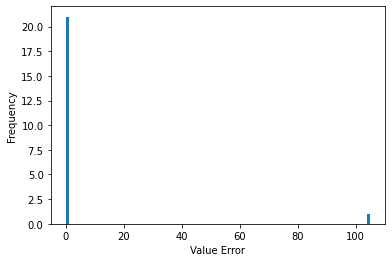

test cost:  1.771911859512329 loss 0: 0.7710614800453186 loss 1: 1.0008503198623657
[[ 24 386]
 [ 37 805]]
Hgb AUC:0.5520827298534268, accuracy:0.6621405750798722, precision:0.39344262295081966, recall:0.05853658536585366, specificity:0.9560570071258907, f1:0.10191082802547771
reduce num: 61.0
reduce prop: 0.048722044728434506
Value prediction accuracies: {0.03: (0.16613418530351437, 0.18032786885245902), 0.06: (0.36182108626198084, 0.29508196721311475), 0.1: (0.5447284345047924, 0.5081967213114754), 0.15: (0.7036741214057508, 0.6885245901639344), 0.2: (0.8011182108626198, 0.7540983606557377)}


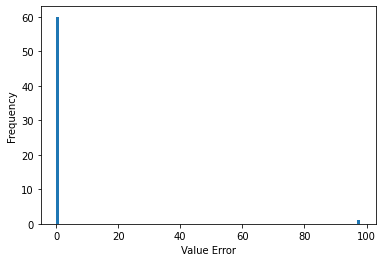

test cost:  1.8036794662475586 loss 0: 0.7427598834037781 loss 1: 1.0609196424484253
[[ 39 371]
 [ 51 791]]
Hgb AUC:0.565458258501825, accuracy:0.6629392971246006, precision:0.43333333333333335, recall:0.0951219512195122, specificity:0.9394299287410927, f1:0.156
reduce num: 90.0
reduce prop: 0.07188498402555911
Value prediction accuracies: {0.03: (0.19249201277955272, 0.24444444444444444), 0.06: (0.35303514376996803, 0.43333333333333335), 0.1: (0.5455271565495208, 0.6111111111111112), 0.15: (0.707667731629393, 0.7333333333333333), 0.2: (0.7987220447284346, 0.7555555555555555)}


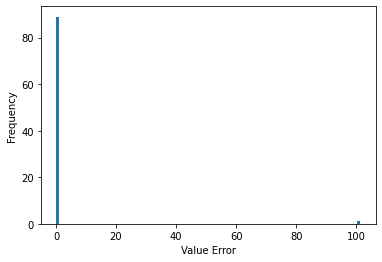

test cost:  1.3173151016235352 loss 0: 0.762385368347168 loss 1: 0.5549296736717224
[[ 57 353]
 [100 742]]
Hgb AUC:0.5482590811656335, accuracy:0.6381789137380192, precision:0.3630573248407643, recall:0.13902439024390245, specificity:0.8812351543942993, f1:0.20105820105820105
reduce num: 157.0
reduce prop: 0.1253993610223642
Value prediction accuracies: {0.03: (0.17252396166134185, 0.21656050955414013), 0.06: (0.33706070287539935, 0.4394904458598726), 0.1: (0.5391373801916933, 0.6305732484076433), 0.15: (0.7124600638977636, 0.7579617834394905), 0.2: (0.8091054313099042, 0.8280254777070064)}


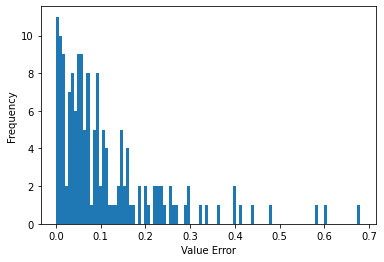

test cost:  1.8349473476409912 loss 0: 0.7886995673179626 loss 1: 1.0462477207183838
[[ 95 315]
 [140 702]]
Hgb AUC:0.5472394415155553, accuracy:0.6365814696485623, precision:0.40425531914893614, recall:0.23170731707317074, specificity:0.833729216152019, f1:0.29457364341085274
reduce num: 235.0
reduce prop: 0.1876996805111821
Value prediction accuracies: {0.03: (0.18210862619808307, 0.2425531914893617), 0.06: (0.3258785942492013, 0.3829787234042553), 0.1: (0.5063897763578274, 0.5787234042553191), 0.15: (0.689297124600639, 0.7659574468085106), 0.2: (0.799520766773163, 0.8765957446808511)}


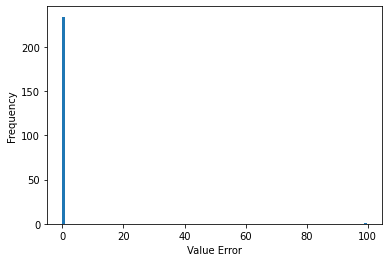

test cost:  1.632551908493042 loss 0: 0.755674421787262 loss 1: 0.8768774271011353
[[135 275]
 [188 654]]
Hgb AUC:0.572620358032559, accuracy:0.6301916932907349, precision:0.4179566563467492, recall:0.32926829268292684, specificity:0.7767220902612827, f1:0.3683492496589359
reduce num: 323.0
reduce prop: 0.25798722044728434
Value prediction accuracies: {0.03: (0.17172523961661343, 0.19814241486068113), 0.06: (0.32987220447284343, 0.39009287925696595), 0.1: (0.5, 0.5758513931888545), 0.15: (0.6813099041533547, 0.7368421052631579), 0.2: (0.797923322683706, 0.8452012383900929)}


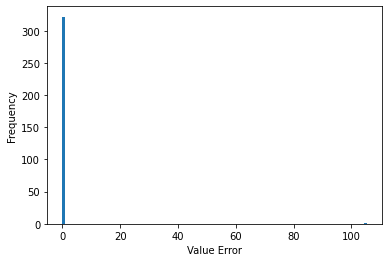

test cost:  1.2266381978988647 loss 0: 0.7845285534858704 loss 1: 0.4421096444129944
[[145 265]
 [256 586]]
Hgb AUC:0.5349545217542437, accuracy:0.5838658146964856, precision:0.36159600997506236, recall:0.35365853658536583, specificity:0.6959619952494062, f1:0.3575832305795314
reduce num: 401.0
reduce prop: 0.32028753993610226
Value prediction accuracies: {0.03: (0.1597444089456869, 0.18204488778054864), 0.06: (0.329073482428115, 0.3790523690773067), 0.1: (0.5047923322683706, 0.57356608478803), 0.15: (0.6861022364217252, 0.7281795511221946), 0.2: (0.8043130990415336, 0.8503740648379052)}


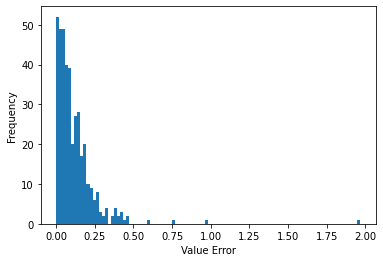

test cost:  1.0036537647247314 loss 0: 0.7840973734855652 loss 1: 0.21955637633800507
[[177 233]
 [312 530]]
Hgb AUC:0.5465703029951915, accuracy:0.5646964856230032, precision:0.3619631901840491, recall:0.4317073170731707, specificity:0.6294536817102138, f1:0.39377085650723026
reduce num: 489.0
reduce prop: 0.39057507987220447
Value prediction accuracies: {0.03: (0.15415335463258786, 0.15950920245398773), 0.06: (0.2963258785942492, 0.32719836400818), 0.1: (0.48482428115015974, 0.5173824130879345), 0.15: (0.6789137380191693, 0.7157464212678937), 0.2: (0.7819488817891374, 0.8179959100204499)}


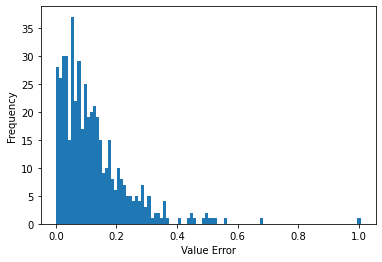

test cost:  1.3454548120498657 loss 0: 0.780144453048706 loss 1: 0.5653103590011597
[[207 203]
 [360 482]]
Hgb AUC:0.5452783732112856, accuracy:0.5503194888178914, precision:0.36507936507936506, recall:0.5048780487804878, specificity:0.5724465558194775, f1:0.42374616171954965
reduce num: 567.0
reduce prop: 0.4528753993610224
Value prediction accuracies: {0.03: (0.15175718849840256, 0.18342151675485008), 0.06: (0.2987220447284345, 0.3368606701940035), 0.1: (0.4840255591054313, 0.5149911816578483), 0.15: (0.6365814696485623, 0.6790123456790124), 0.2: (0.7659744408945687, 0.800705467372134)}


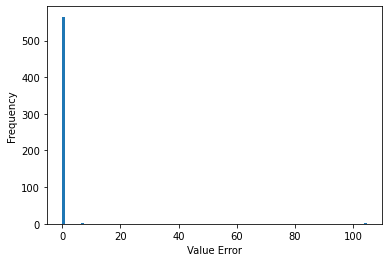

test cost:  1.3743360042572021 loss 0: 0.7865333557128906 loss 1: 0.5878026485443115
[[235 175]
 [452 390]]
Hgb AUC:0.5291755981692834, accuracy:0.4992012779552716, precision:0.3420669577874818, recall:0.573170731707317, specificity:0.46318289786223277, f1:0.4284412032816773
reduce num: 687.0
reduce prop: 0.5487220447284346
Value prediction accuracies: {0.03: (0.14376996805111822, 0.14264919941775836), 0.06: (0.28833865814696485, 0.30131004366812225), 0.1: (0.4672523961661342, 0.5007278020378457), 0.15: (0.6517571884984026, 0.6899563318777293), 0.2: (0.7731629392971247, 0.8107714701601164)}


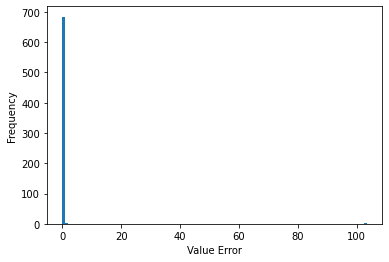

test cost:  1.3385093212127686 loss 0: 0.7916390299797058 loss 1: 0.546870231628418
[[267 143]
 [521 321]]
Hgb AUC:0.5316783500376572, accuracy:0.4696485623003195, precision:0.33883248730964466, recall:0.651219512195122, specificity:0.3812351543942993, f1:0.44574290484140233
reduce num: 788.0
reduce prop: 0.6293929712460063
Value prediction accuracies: {0.03: (0.13817891373801916, 0.14086294416243655), 0.06: (0.2979233226837061, 0.31091370558375636), 0.1: (0.46884984025559107, 0.48350253807106597), 0.15: (0.6461661341853036, 0.6649746192893401), 0.2: (0.7563897763578274, 0.7880710659898477)}


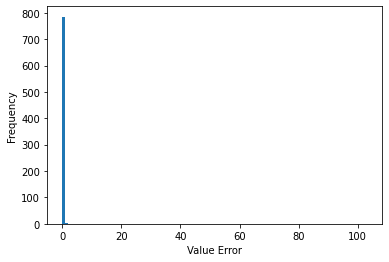

test cost:  1.372847318649292 loss 0: 0.797853410243988 loss 1: 0.5749938488006592
[[295 115]
 [591 251]]
Hgb AUC:0.5164590695788194, accuracy:0.43610223642172524, precision:0.3329571106094808, recall:0.7195121951219512, specificity:0.2980997624703088, f1:0.4552469135802469
reduce num: 886.0
reduce prop: 0.707667731629393
Value prediction accuracies: {0.03: (0.13338658146964857, 0.1399548532731377), 0.06: (0.28115015974440893, 0.3013544018058691), 0.1: (0.43929712460063897, 0.46613995485327314), 0.15: (0.6150159744408946, 0.6557562076749436), 0.2: (0.744408945686901, 0.781038374717833)}


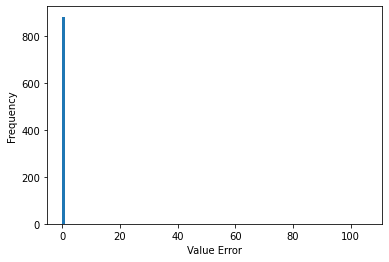

test cost:  1.4729728698730469 loss 0: 0.8108867406845093 loss 1: 0.6620861291885376
[[320  90]
 [653 189]]
Hgb AUC:0.5062684664851399, accuracy:0.40654952076677314, precision:0.328879753340185, recall:0.7804878048780488, specificity:0.22446555819477435, f1:0.46276211135213297
reduce num: 973.0
reduce prop: 0.7771565495207667
Value prediction accuracies: {0.03: (0.12460063897763578, 0.1264131551901336), 0.06: (0.2723642172523962, 0.28263103802672146), 0.1: (0.4233226837060703, 0.44295991778006166), 0.15: (0.6086261980830671, 0.6372045220966084), 0.2: (0.7380191693290735, 0.7646454265159301)}


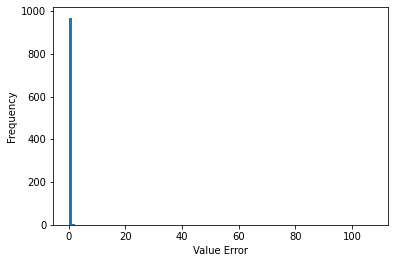

test cost:  1.3476262092590332 loss 0: 0.8285912275314331 loss 1: 0.5190349221229553
[[355  55]
 [710 132]]
Hgb AUC:0.4997653670123399, accuracy:0.3889776357827476, precision:0.3333333333333333, recall:0.8658536585365854, specificity:0.15676959619952494, f1:0.48135593220338974
reduce num: 1065.0
reduce prop: 0.8506389776357828
Value prediction accuracies: {0.03: (0.14297124600638977, 0.14272300469483568), 0.06: (0.2795527156549521, 0.29014084507042254), 0.1: (0.43929712460063897, 0.4591549295774648), 0.15: (0.5998402555910544, 0.6225352112676056), 0.2: (0.7348242811501597, 0.7586854460093897)}


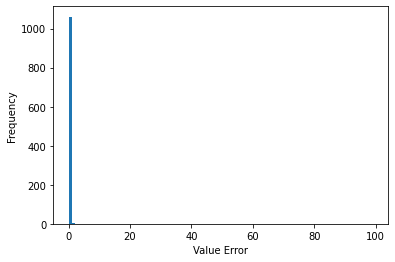

test cost:  1.5543718338012695 loss 0: 0.8999935984611511 loss 1: 0.6543782949447632
[[410   0]
 [842   0]]
Hgb AUC:0.48570621632582117, accuracy:0.3274760383386581, precision:0.3274760383386581, recall:1.0, specificity:0.0, f1:0.49338146811071
reduce num: 1252.0
reduce prop: 1.0
Value prediction accuracies: {0.03: (0.12060702875399361, 0.12060702875399361), 0.06: (0.2571884984025559, 0.2571884984025559), 0.1: (0.4049520766773163, 0.4049520766773163), 0.15: (0.5878594249201278, 0.5878594249201278), 0.2: (0.6980830670926518, 0.6980830670926518)}


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in long_scalars


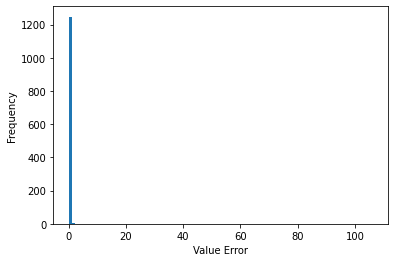

time: 27.6 s


In [47]:
reduce_prop_all = []
result_all = []
accuracy_all = []
auc_all = []
recall_all = []
specificity_all = []
for point in np.arange(0,1,0.05)+0.05:
    reduce_prop, result_temp, accuracy, auc, recall, specificity = evaluate(comb_model, test_mask, \
                                                                            threshold_point=point,show_details=True)
    if len(result_temp) == 0:
        continue
    reduce_prop_all.append(reduce_prop)
    result_all.append(result_temp)
    accuracy_all.append(accuracy)
    auc_all.append(auc)
    recall_all.append(recall)
    specificity_all.append(specificity)

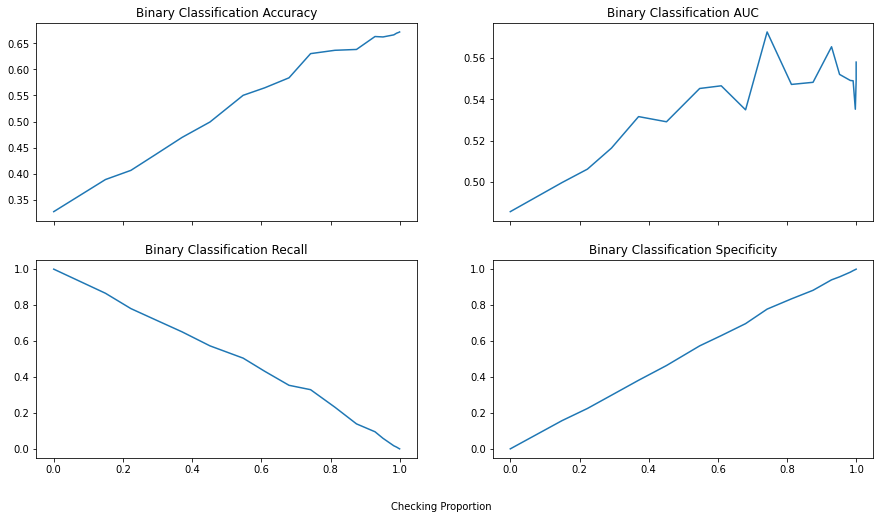

time: 432 ms


In [48]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True,figsize=(15,8))
ax1.plot(1-np.array(reduce_prop_all),np.array(accuracy_all))
ax2.plot(1-np.array(reduce_prop_all),np.array(auc_all))
ax3.plot(1-np.array(reduce_prop_all),np.array(recall_all))
ax4.plot(1-np.array(reduce_prop_all),np.array(specificity_all))
# plt.title('Binary Classification Accuracy')
ax1.set_title('Binary Classification Accuracy')
ax2.set_title('Binary Classification AUC')
ax3.set_title('Binary Classification Recall')
ax4.set_title('Binary Classification Specificity')
fig.text(0.5,0.04, 'Checking Proportion', ha="center", va="center",fontsize=10)
# fig.text(0.05,0.5, '', ha="center", va="center", rotation=90,fontsize=10)
plt.show()

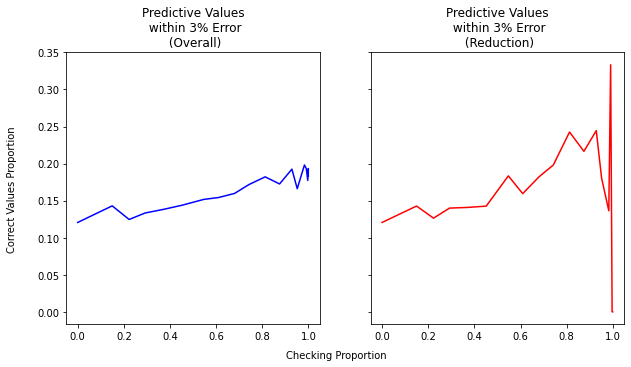

time: 265 ms


In [49]:
## 3%
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(10,5))
ax1.plot(1-np.array(reduce_prop_all),np.array([item[0.03][0] for item in result_all]), color='b')
ax2.plot(1-np.array(reduce_prop_all),np.array([item[0.03][1] for item in result_all]), color='r')

ax1.set_title('Predictive Values\n within 3% Error\n (Overall)')
ax2.set_title('Predictive Values\n within 3% Error\n (Reduction)')
fig.text(0.5,0.04, 'Checking Proportion', ha="center", va="center",fontsize=10)
fig.text(0.05,0.5, 'Correct Values Proportion', ha="center", va="center", rotation=90,fontsize=10)
plt.show()

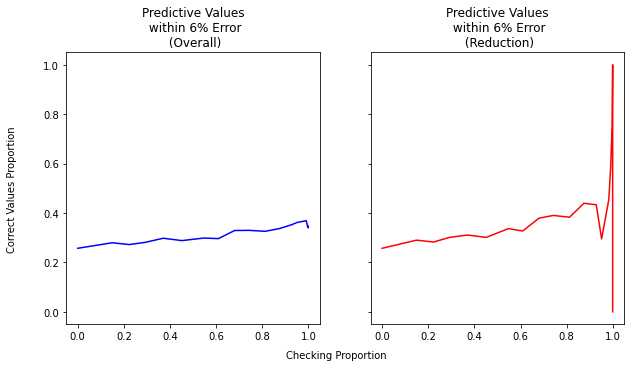

time: 229 ms


In [50]:
## 6%
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(10,5))
ax1.plot(1-np.array(reduce_prop_all),np.array([item[0.06][0] for item in result_all]), color='b')
ax2.plot(1-np.array(reduce_prop_all),np.array([item[0.06][1] for item in result_all]), color='r')
ax1.set_title('Predictive Values\n within 6% Error\n (Overall)')
ax2.set_title('Predictive Values\n within 6% Error\n (Reduction)')
fig.text(0.5,0.04, 'Checking Proportion', ha="center", va="center",fontsize=10)
fig.text(0.05,0.5, 'Correct Values Proportion', ha="center", va="center", rotation=90,fontsize=10)
plt.show()

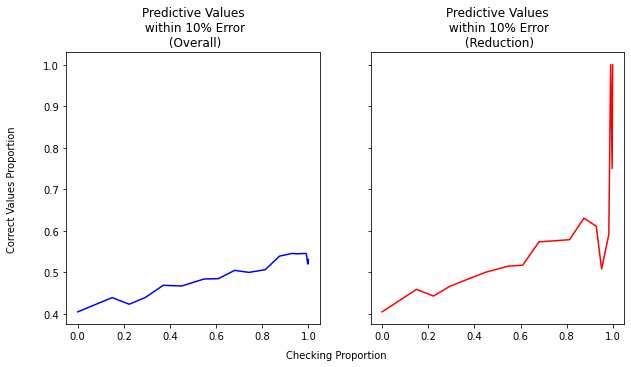

time: 266 ms


In [51]:
## 10%
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(10,5))
ax1.plot(1-np.array(reduce_prop_all),np.array([item[0.1][0] for item in result_all]), color='b')
ax2.plot(1-np.array(reduce_prop_all),np.array([item[0.1][1] for item in result_all]), color='r')
ax1.set_title('Predictive Values\n within 10% Error\n (Overall)')
ax2.set_title('Predictive Values\n within 10% Error\n (Reduction)')
fig.text(0.5,0.04, 'Checking Proportion', ha="center", va="center",fontsize=10)
fig.text(0.05,0.5, 'Correct Values Proportion', ha="center", va="center", rotation=90,fontsize=10)
plt.show()

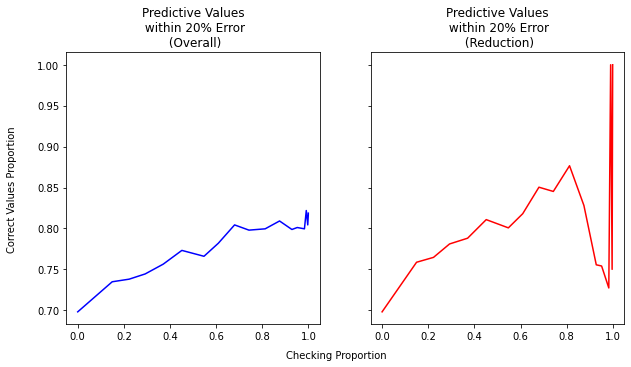

time: 241 ms


In [52]:
## 20%
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(10,5))
ax1.plot(1-np.array(reduce_prop_all),np.array([item[0.2][0] for item in result_all]), color='b')
ax2.plot(1-np.array(reduce_prop_all),np.array([item[0.2][1] for item in result_all]), color='r')
ax1.set_title('Predictive Values\n within 20% Error\n (Overall)')
ax2.set_title('Predictive Values\n within 20% Error\n (Reduction)')
fig.text(0.5,0.04, 'Checking Proportion', ha="center", va="center",fontsize=10)
fig.text(0.05,0.5, 'Correct Values Proportion', ha="center", va="center", rotation=90,fontsize=10)
plt.show()